<img src="header.png"></img>

<div align="center">
    <font size=5><b>Тестовое задание</b></font>
    <br/><font size=2.5><i>(для аналитика больших данных)</i></font>
</div>
<div align="center"><i>
    <br/>Настоящий Jupyter ноутбук представляет собой возможную концепцию решения поставленной задачи
    <br/>При выполнении данного была предпринята попытка, скорее, собрать MVP, нежели натренировать отдельно взятую модель
    <br/>
    <br/>Представленная концепция способна дать неплохие <u>baseline</u> результаты
    <br/>для выявления 2-ой сим-карты, принадлежащей той же Персоне, которой принадлежит 1-ая
    <br/>В частности, <u>точность</u> на тестовой выборке составила <u>36% (при высоковероятном наличии потенциала для улучшения)</u>
    <br/>
    <br/>Однако из-за отсутсвия информации о Персонах, у которых <u>точно / высоковероятно</u> нет других сим-карт
    <br/>остаётся открытым вопрос отнесения каждой сим-карты к классам  
    <br/>"0" - у владельца сим-карты нет других сим-карт или "1" - у владельца сим-карты есть другие сим-карты,
    <br/>ответ на который является критичным для правильной имплементации представленной концепции
    <br/>
    <br/>В настоящий момент мы можем найти пару для любой сим-карты, но оценить, насколько мы правы, в случаях, когда
    <br/>у владельца 1-ой сим-карты нет 2-ой сим-карты возможности не представляется.
    <br/>Эту задачу можно пробовать решать методами кластеризации, однако, как мне кажется,
    <br/>за рамками настоящего задания требующиеся данные должны существовать (и являются легкодоступными для телеком-компании)
    <br/>
    <br/>Также следует отметить, что в рамках решения не рассматривались случаи, когда у владельца более 2-х сим-карт
    <br/>
    <br/>подготовил Артём Дрофа
    </i>
</div>

In [82]:
GENERATE = False
# False: support files (generated in advance) needed
# True: all files will be generated (will take sufficient time. Depends on your PC, of course :-) )

<font color='57068c'><i>Обращаю ваше внимание, что тест запуска ноутбука целиком при GENERATE = True не производился (с результатами такого теста смогу вернуться в ближайшее время)</i></font>

In [2]:
# Main
import pandas as pd
import numpy as np

# Calculations
import math
from collections import Counter
from scipy.spatial.distance import cosine

# Geography
from geographiclib.geodesic import Geodesic
from shapely.geometry import Polygon

# System
import multiprocessing.dummy as mp
from functools import partial
import pickle
import time
from tqdm import tqdm_notebook as tqdm
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display as print_df

# SKLearn
# -- Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
# -- Metrics
from sklearn.metrics import log_loss
# -- Preprocessing
from sklearn.preprocessing import StandardScaler
# -- Models
from sklearn.linear_model import SGDClassifier, LogisticRegression

import lightgbm as lgb

# Statistics
from statsmodels.stats.weightstats import _tconfint_generic
from statsmodels.stats.proportion import proportion_confint

# Warnings
import warnings
warnings.filterwarnings('ignore')

Загрузим предоставленные данные (таблицу `Data`)

In [3]:
data = pd.read_csv('02_Data.csv', sep=';'); data.head(3)

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
0,5029,40798,158529599791,3.531111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0
1,7782,56870,158520145943,1.292900e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45.0,105.0
2,7794,32226,158521798391,3.519940e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0.0,60.0


В данных нет уникального идентификатора строки (в частности, комбинация `msisdn` (далее также - "номер телефона", "сим-карта") и `tstamp` таковым не является). Создадим такой идентификатор

In [4]:
data['unique_id'] = range(len(data))
data['unique_id'] = data['unique_id'].astype(str) + '_' + data.msisdn.astype(str) + '_' + data.tstamp.astype(str)

In [5]:
print('Кол-во уникальных msisdn:', data.msisdn.nunique())

Кол-во уникальных msisdn: 2361


Загрузим таблицу с парами сим-карт, принадлежащих одному человеку

In [6]:
facts = pd.read_excel('01_Факты.xlsx', header=None); assert facts.equals(facts.drop_duplicates())
print('facts.shape =', facts.shape); print_df(facts.head(3))

facts_ids = np.unique(facts.values.flatten()).tolist(); print('# of unique msisdns in facts:', len(facts_ids))
facts_ids = [msisdn for msisdn in facts_ids if msisdn in data.msisdn.tolist()]; print('# of unique msisdns, which exist in data:', len(facts_ids))

facts_ids_0 = facts.iloc[:, 0].tolist(); facts_ids_1 = facts.iloc[:, 1].tolist()

facts.shape = (122, 2)


,0,1
0,158530067653,158528861653
1,158510912201,158528852857
2,158530063945,158528861599


# of unique msisdns in facts: 243
# of unique msisdns, which exist in data: 241


In [7]:
pairs_0 = [[i, j] for i, j in zip(facts_ids_0, facts_ids_1)
           if i in data.msisdn.tolist() and j in data.msisdn.tolist()]
pairs_1 = [[i, j] for i, j in zip(facts_ids_1, facts_ids_0)
           if i in data.msisdn.tolist() and j in data.msisdn.tolist()]

pairs = pairs_0 + pairs_1; pairs = pd.DataFrame(pairs).drop_duplicates().values.tolist()
print('len(pairs) =', len(pairs))

pairs_train, pairs_unseen = train_test_split(pairs, test_size=0.33, shuffle=True, random_state=17)
print('len(pairs_train) =', len(pairs_train))
print('len(pairs_unseen) =', len(pairs_unseen))

len(pairs) = 240
len(pairs_train) = 160
len(pairs_unseen) = 80


## <font color='57068c'>Где делать <b>#fitpredict?</b></font>

Поскольку:
* набор предоставленных пар из номеров телефонов равняется <font color='00985f'><b>240</b></font> (всего 120 пар, плюс, их зеркальное отображение);
* общее количество уникальных msisdn составляет 2361, что трансформируется в <font color='00985f'><b>~5.6 млн.</b></font> возможных пар (по формуле комбинаторики для вычисления числа размещений);
* сгенерировать все возможные пары, разметить их (0 и 1) и <font color='00985f'><b>обучать модель на такой выборке представляется затруднительным</b></font> по двум причинам: (1) слишком малое количество «1»; (2) высокая вычислительная стоимость*

<font color='666666'><i>* Подразумевается, что, как минимум, мой лэптоп с таким будет справляться слишком долго :-)</i></font>

## <font color='57068c'>Идея 1: формулировка</font>
Чтобы хоть как-то продвинуться с решением была сформулирована следующая идея:

<font color='57068c'><u><i>«Наверное, сим-карты, которыми владеет 1 человек, должны с высокой периодичностью регистрироваться
    <br/>на одних (или пересекающихся по зонам действия) базовых станциях в одно время»</i></u></font>

В рамках данной идеи было сделано <font color='00985f'><b>предположение</b></font>, что <font color='00985f'><b>Персоны</b></font>, которых мы пытаемся идентифицировать, <font color='00985f'><b>покупают сим-карты только для себя</b></font> (а не для других людей, например, случай "мама покупает сим-карту дочке" игнорируется)

## <font color='57068c'>Идея 1: реализация</font>
### <font color='00985f'><b>Шаг 1:</b></font>
для каждой строки (не сим-карты) в исходной таблице построить:
* <font color='00985f'><b>гео-зону</b></font>, в которой находится сим-карта в момент регистрации на базовой станции;
* <font color='00985f'><b>временной промежуток</b></font>, в который сим-карта находится в этой гео-зоне (начало — время регистрации на этой базовой станции, окончание — время регистрации на другой базовой станции);

### <font color='00985f'><b>Шаг 2:</b></font>
<font color='00985f'><b>для каждой сим-карты собрать</b></font> списки других сим-карт, с гео-зонами которых пересекалась гео-зона первой в пересекающиеся временные промежутки, т.е. <font color='00985f'><b>списки тех сим-карт, с которыми первая могла находится в  одном месте в одно время</b></font>

Из описания задания становится ясно, что зона покрытия базовой станции представляет собой сектор, посмотрим на углы таких секторов более детально

In [8]:
data['angle'] = data.end_angle - data.start_angle
data.angle.value_counts()

 60.0     129525
-300.0     27448
 47.0       8186
-270.0      3013
 360.0      2184
 65.0       1808
-313.0      1536
-295.0       327
 90.0         96
Name: angle, dtype: int64

Видно, что иногда это не сектора, а круги. Трансформируем данные так, чтобы угол (азимут) начала сектора был всегда меньше угла его конца

In [9]:
data.loc[data.angle < 0, 'start_angle'] = data.start_angle - 360
data['angle'] = data.end_angle - data.start_angle

data.angle.value_counts(dropna=False)

60.0     156973
47.0       9722
90.0       3109
360.0      2184
65.0       2135
Name: angle, dtype: int64

Теперь посмотрим на зону, которую предстоит анализировать, для этого выделим самую левую нижнюю и самую правую верхнюю точки

In [10]:
print('min:')
print(data.lat.min(), data.long.min())

print('max:')
print(data.lat.max(), data.long.max())

min:
54.3736 35.2578
max:
56.8372 39.8923


<img src="map.png"></img>

Исследуемая площадь не очень большая (относительно всей земной поверхности), в связи с этим, пренебрежем тем, что Земля не плоская:
* для определения точек на карте будем использовать библиотеку `geographiclib`
* а в последствии с территорией будем работать, как с прямоугольником, используя библиотеку `shapely`

Библиотека `shapely` не может создать `polygon` (т.е. геометрический объект) в форме сектора, поэтому аппроксимируем кружность сектора прямыми:

<img src="sector.png"></img>

(По умолчанию) дугу в 60° будем аппроксимировать 5-ю отрезками, т.е. 1 отрезок на 12°.
<br/>Для этого зададим ф-цию, которая вернет список из новых углов, вида `[start_angle, ..., ..., ..., end_angle]`

In [11]:
def split_angle(start_angle, end_angle, degree_per_split=12):
    """Returns a list of sub-angles in the stated angle range.
    Default degree_per_split value equals to 12°, which leads to 5 splits for 60° sector.
    """
    
    start_angle_normed = start_angle / 360
    end_angle_normed = end_angle / 360
    degree_per_split_normed = degree_per_split / 360
    
    delta_normed = end_angle_normed - start_angle_normed
    degree_per_split = delta_normed / degree_per_split_normed
    degree_per_split_int = int(round(degree_per_split, 0))
    
    sub_angles_normed = np.linspace(start_angle_normed, end_angle_normed, degree_per_split_int+1)
    sub_angles = list(sub_angles_normed * 360)
    
    assert round(sub_angles[0], 3) == start_angle, 'Error in angles split: `start_angle`!'
    # sub_angles[0] = start_angle
    assert round(sub_angles[-1], 3) == end_angle, 'Error in angles split: `end_angle`!'
    # sub_angles[-1] = end_angle
    
    return sub_angles

Также зададим ф-цию, которая вернет координаты точки, расположенной на окружности, описанной (1) координатами центра окружности, (2)расстоянием от центра и (3) углом отклонения от севера

In [12]:
def find_point(lat, lon, angle, dist):
    """Returns [lon, lat] for a point described with: center,
    radius and azimut (i.e. performes direct geodesic task).
    """
    
    point = Geodesic.WGS84.Direct(lat, lon, angle, dist)
    
    lat_found = point['lat2']
    lon_found = point['lon2']
    
    return [lon_found, lat_found]

Этих двух ф-ций будет достаточно, чтобы задать ф-цию, которая вернет `polygon` аппроксимации сектора, т.е. зоны покрытия базовой станции

In [13]:
def generate_polygon(lat, lon, start_angle, end_angle, dist, degree_per_split=12):
    """Generates Polygon class (from Shapely) object, which is equivalent to a sector,
    defined with its center coordinate (lat, lon) and start-, end- _angle.
    """
    
    polygon_points = []
    sub_angles = split_angle(start_angle, end_angle, degree_per_split)
     
    if (end_angle - start_angle) == 360:
        # otherwise intersection method doesn't work (because polygon has incorrect shape)
        sub_angles = sub_angles[0:-1]
    else:
        # adding sctor's center (if polygon is not circle, i.e. angle != 360°)
        polygon_points.append([lon, lat])

    for angle in sub_angles:
        new_point = find_point(lat, lon, angle, dist)
        polygon_points.append(new_point)

    polygon = Polygon(polygon_points)

    return polygon

Также понадобится модификации ф-ции `generate_polygon`, которые можно будет применить:
* к строке из таблицы `Data` - `generate_polygon_apply_to_row`
* ко всей таблице `Data` - `create_polygon_col`

In [14]:
def generate_polygon_apply_to_row(row, degree_per_split=12):
    """Applies generate_polygon() to a row of the original dataset."""
    
    lat = row['lat']
    lon = row['long']
    start_angle = row['start_angle']
    end_angle = row['end_angle']
    dist = row['max_dist']
    
    polygon = generate_polygon(lat, lon, start_angle, end_angle, dist, degree_per_split)
    
    return polygon

<i>Пример:</i>

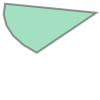

In [15]:
generate_polygon_apply_to_row(data.iloc[0, :])

Т.к. вычисления довольно "тяжелые", не будем игнорировать `multithreading`

In [16]:
def create_polygon_col(data, degree_per_split=12, processes=4):
    """Returns `data` DataFrame with generated 'polygon' column."""
    
    lst_of_dct = data.to_dict('records')
    
    pool = mp.Pool(processes)
    polygons = [row for row in pool.map(generate_polygon_apply_to_row, lst_of_dct)]
    
    data_new = data.copy()
    data_new['polygon'] = polygons
    
    return data_new

In [17]:
if GENERATE:
    data = create_polygon_col(data)
    
    with open('data_polygon_col.pkl', 'wb') as file:
        pickle.dump(data, file)

else:
    with open('data_polygon_col.pkl', 'rb') as file:
        data = pickle.load(file)

Теперь зададим ф-ции, которые позволят сгенерировать окончания периодов регистрации на базовых станциях:
* для DataFrame, в котором представлены записи только для одной сим-карты - `create_tstamp_end_for_msisdn`, и
* для всего набора данных - `create_tstamp_end_col`

In [18]:
def create_tstamp_end_for_msisdn(data_msisdn):
    """ Creates the end of a sim-card 'registration' period at a base station,
    where the end of the period equals to the next fixed `tstamp` (and the start of
    the period equals to `tstamp`).
    
    Args:
        data_msisdn (pandas.core.frame.DataFrame): slice of `data` for one `msisdn`
    """
    
    
    data_msisdn = data_msisdn.sort_values(by='tstamp').copy()
    
    data_msisdn['tstamp_end'] = data_msisdn['tstamp'].shift(-1)
    data_msisdn['duration'] = data_msisdn.tstamp_end - data_msisdn.tstamp
    
    data_msisdn['duration'] = data_msisdn['duration'].fillna(data_msisdn['duration'].max())
    data_msisdn['tstamp_end'] = data_msisdn.tstamp + data_msisdn.duration
    
    return data_msisdn

<i>Пример:</i>

In [19]:
create_tstamp_end_for_msisdn(data[data.msisdn == data.msisdn[1]])[['msisdn', 'tstamp', 'tstamp_end', 'duration']].head(3)

,msisdn,tstamp,tstamp_end,duration
1,158520145943,1369252801396,1.369283e+12,30509844.0
9786,158520145943,1369283311240,1.369284e+12,248568.0
9940,158520145943,1369283559808,1.369284e+12,103165.0


Также не будем пренебрегать `multithreading`'ом

In [20]:
def create_tstamp_end_col(data, processes=4):
    """Returns `data` DataFrame with generated
    'tstamp_end' and `duration` columns.
    """
    
    data_lst = [data[data.msisdn == msisdn].copy() for msisdn in data.msisdn.unique()]
    
    pool = mp.Pool(processes)
    data_lst = [data_msisdn for data_msisdn in pool.map(create_tstamp_end_for_msisdn, data_lst)]
    
    data_new = pd.concat(data_lst).sort_index()
    pd.util.testing.assert_frame_equal(data, data_new[data.columns], check_dtype=False)
    
    return data_new    

In [21]:
if GENERATE:
    data = create_tstamp_end_col(data)
    
    with open('data_tstamp_end_col.pkl', 'wb') as file:
        pickle.dump(data, file)

else:
    with open('data_tstamp_end_col.pkl', 'rb') as file:
        data = pickle.load(file)

После того, как для каждой записи были сгенерированы:
* гео-зоны, где находилась сим-карта в момент регистрации на базовой станции;
* временной промежуток, в который сим-карта находилась в этой гео-зоне

можно перейти к пересеченям гео-зон (в установленные промежутки времени)

Зададим ф-цию, которая определяет, пересекаются ли `polygon`'ы (ф-ция учитывает не только пересечения, но и касания)

In [22]:
def polygon_intersecton(polygon_a, polygon_b):
    """Returns a result of the stated polygons intersection as
    a boolean value: `True` if the polygons overlap, and `False` if not).
    """
    
    if polygon_a.intersection(polygon_b):
        return True
    else:
        return False

Поскольку нам необходимо для каждой строки проверить пересечение `polygon`'а с каждой другой строкой, то для оптимизации этого процесса:
* поделим всю зону на секторы (дефолтное значение - 9 секторов, т.е. каждая сторона разделена на 3 равных отрезка);
* найдем пересечения каждого `polygon`'а с каждой зоной;
* впоследствии (при пересечении всех строк) будем отфильтровывать строки по пересечениям с зонами

<i>P.S.
    <br/>На незначительном объеме данных эта оптимизация показала <u>ускорение до x2</u></i>

Зададим ф-цию для создания зон:

In [23]:
def create_zones(data, side_split=3):
    """Extends area (considered in the framework of `data`) on `max_dist`,
    splits each side on `side_splits` and returns dict of polygons
    in amount of `side_split**2` (for each side).
    """

    max_dist = data.max_dist.max()

    lon_min, lat_min = data.long.min(), data.lat.min() # left-bottom corner
    lon_max, lat_max = data.long.max(), data.lat.max() # right-top corner

    lon_min, lat_min = find_point(lat_min, lon_min, 180+45, max_dist) # left-bottom corner moved on max_dist
    lon_max, lat_max = find_point(lat_max, lon_max, 45, max_dist) # right-top corner moved on max_dist

    lon_side = np.linspace(lon_min, lon_max, side_split+1) # * np.ones((side_split+1, side_split+1))
    lat_side = np.linspace(lat_min, lat_max, side_split+1) # * np.ones((side_split+1, side_split+1))

    zones = {}
    for lon_i in range(side_split):
        left = lon_side[lon_i]
        right = lon_side[lon_i+1]

        for lat_i in range(side_split):
            bottom = lat_side[lat_i]
            top = lat_side[lat_i+1]

            left_bottom = [left, bottom]
            left_top = [left, top]
            right_top = [right, top]
            right_bottom = [right, bottom]

            zone_points = [left_bottom, left_top, right_top, right_bottom]
            zone = Polygon(zone_points)

            zone_name = '{}_x_{}'.format(lon_i+1, lat_i+1)
            zones[zone_name] = zone

    return zones

Пример зоны:


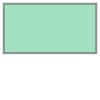

In [24]:
zones = create_zones(data, side_split=3); print('Пример зоны:'); zones['1_x_1']

Создадим колонки в кол-ве зон, в которых для каждого msisdn будет "1" - если `polygon` строки пересекается с зоной, и "0" - если нет

In [25]:
def create_zones_cols(data, zones, side_split=3):
    """Generates columns (in amount of `side_split`**2), which indicate
    if a `data` entry intersects the specified zone: 1 for 'yes', 0 for 'no'.
    """
    
    for col in data.columns:
        if 'zone_' in col:
            raise Exception('Zones have been already created!')
    
    data_new = data.copy()
    
    zones = create_zones(data, side_split)
    zones_ids = list( zones.keys() )
    
    for zone_id in zones_ids:
        zone = zones[zone_id]
        data_new['zone_'+zone_id] = data_new.polygon.apply(polygon_intersecton, polygon_b=zone)
        data_new['zone_'+zone_id] = data_new['zone_'+zone_id].map({False:0, True:1})
        
    return data_new

In [26]:
if GENERATE:
    data = create_zones_cols(data, zones, side_split=5)
    
    with open('data_zones_cols.pkl', 'wb') as file:
        pickle.dump(data, file)

else:
    with open('data_zones_cols.pkl', 'rb') as file:
        data = pickle.load(file)

<i>Пример:</i>

In [27]:
data[[col for col in data.columns if 'zone_' in col]].head(3)

,zone_1_x_1,zone_1_x_2,zone_1_x_3,zone_1_x_4,zone_1_x_5,zone_2_x_1,zone_2_x_2,zone_2_x_3,zone_2_x_4,zone_2_x_5,...,zone_4_x_1,zone_4_x_2,zone_4_x_3,zone_4_x_4,zone_4_x_5,zone_5_x_1,zone_5_x_2,zone_5_x_3,zone_5_x_4,zone_5_x_5
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Зададим ф-цию, которая ищет `polygon`'ы, с которыми пересекается `polygon` из переданной строки

Напомним, что <b>пересечения мы ищем не только по географии, но и по времени!</b>

In [28]:
def find_intersections_for_row(row):
    """Returns row's `msisdn` and a set of msisdns, which intersects with this row
    by time and location, as a list.
    """
    
    msisdn = row['msisdn']
    unique_id = row['unique_id']
    tstamp = row['tstamp']
    tstamp_end = row['tstamp_end']
    polygon_a = row['polygon']

    zones = [key for key in row.keys() if 'zone_' in key]
    zone_mask = np.zeros(len(data))
    for zone in zones:
        status = row[zone]
        if status == 1:
            zone_mask += (data[zone] == status)

    zone_mask = (zone_mask > 0)

    mask_tstamp = (data.tstamp.between(tstamp, tstamp_end) & (data.msisdn != msisdn))
    mask_tstamp_end = (data.tstamp_end.between(tstamp, tstamp_end) & (data.msisdn != msisdn))

    mask = (mask_tstamp | mask_tstamp_end) & zone_mask
    data_masked = data[mask]
    polygons = data_masked.polygon.tolist()

    if len(polygons) > 0:
        polygons_mask = [polygon_intersecton(polygon_a, polygon_b) for polygon_b in polygons]
        intersection = list( set(data_masked[polygons_mask].msisdn) )
    else:
        intersection = list( set() )

    return [unique_id, msisdn, intersection]

Зададим ф-цию, которая позволяет найти пересечения `polygon`'ов не только для одной строки, а для всего датасета (`data`)

In [29]:
def create_intersections_raw(data, ids=None, processes=4):
    """Returns list of lists, where each list is a result of find_intersections_for_row()
    application for specified msisdns. For msisdns specification list of msisdns should
    be provided as `ids`. 
    """
    
    if ids:
        lst_of_dct = data[data.msisdn.isin(ids)].to_dict('records')
    else:
        lst_of_dct = data.to_dict('records')

    pool = mp.Pool(processes)
    intersections_raw = [row for row in pool.map(find_intersections_for_row, lst_of_dct)]
    
    return intersections_raw

Ф-ция `create_intersections_raw_batch` (ниже) повторяет ф-цию `create_intersections_raw` (выше), отличия:
* обрабатывает строки таблицы `data` кусками (`batch`'ами)
* делает бэкап каждого `batch`'а в виде `pickle` файла

<i>
P.S.
<br/>Ф-цию можно существенно оптимизировать: сейчас ф-ция перебирает каждую строку, однако после нахождения для одной строки пересекающихся polygon'ов можно заполнить другие строки (те, которые вошли в список пересечений) и больше их не перебирать.</i>

In [30]:
def create_intersections_raw_batch(data, ids, processes=4, batch_size=100, name_prefix='tmp', verbose=1):
    """The same as `create_intersections_raw()`, but with:
    - ids split on sub-lists with len equals to (or below for the last batch) `batch_size`;
    - creation of intermediate files while execution;
    - progress status notifications.
    """
    
    ids_len = len(ids)
    batches_num = math.ceil(ids_len / batch_size)
    
    if verbose == 1:
            print('Creation of intersections_raw_batch has been started:')
    files_names = []
    for i in range(batches_num):
        start_time = time.time()
        
        start = batch_size * i
        end = batch_size * (i+1)
        ids_batch = ids[start:end]
        
        intersections_raw_batch = create_intersections_raw(data, ids_batch, processes)
        
        file_name = 'TF_intersections_raw_' + name_prefix + '_{}_of_{}.pkl'.format(i+1, batches_num)
        # TF for 'temprorary file'
        with open(file_name, 'wb') as file:
            pickle.dump(intersections_raw_batch, file)
        del intersections_raw_batch
        files_names.append(file_name)
        
        end_time = time.time()
        time_to_show = round((end_time - start_time) / 60, 2)
        if verbose == 1:
            print('- Batch {} of {} has been processed (time, min.: {}).'
                  .format(i+1, batches_num, time_to_show))
    
    
    intersections_raw = []
    if verbose == 1:
            print('\n', '`intersections_raw` update has been started:')
    for i, file_name in enumerate(files_names):
        
        with open(file_name, 'rb') as file:
            intersections_raw_batch = pickle.load(file)
        
        intersections_raw += intersections_raw_batch
        del intersections_raw_batch
        
        if verbose == 1:
            print('- `intersections_raw` has been updated with batch {} (of {}).'
                  .format(i+1, batches_num))
        
    return intersections_raw

In [31]:
if GENERATE:
    intersections_raw_facts = create_intersections_raw(data, facts_ids, processes=4)
    
    with open('intersections_raw_facts.pkl', 'wb') as file:
        pickle.dump(intersections_raw_facts, file)

else:
    with open('intersections_raw_facts.pkl', 'rb') as file:
        intersections_raw_facts = pickle.load(file)

Ф-ция ниже позволяет преобразовать пересечения из "сырого" формата в формат словаря:
* ключ словаря - это уникальный `msisdn` (т.е. сим-карта)
* значения словаря - другие словари, где:
  * ключи - это `msisdn`'ы, которые пересекает первый `msisdn`
  * значения - кол-во раз, которое он их пересекает

In [32]:
def intersections_raw_processing(intersections_raw, results='count'):
    """Processes `intersections_raw` and returns one of two dicts with
    msisdns as keys and (1) full list of intersections as values, or
    (2) intersections counter as values.
    """

    intersections = {}
    for intersection in intersections_raw:

        msisdn = intersection[1]
        intersection_lst = intersection[2]

        if msisdn not in intersections:
            intersections[msisdn] = intersection_lst
        else:
            intersections[msisdn] += intersection_lst
    
    if results != 'count':
        return intersections
    
    else:
        intersections_count = {}
        for msisdn in intersections:

            intersection_lst = intersections[msisdn]
            intersections_count[msisdn] = dict( Counter(intersection_lst) )

        return intersections_count

In [33]:
intersections_count_facts = intersections_raw_processing(intersections_raw_facts)

Теперь, когда собраны пересечения, попробуем предсказать "парную" сим-карту
<br/>В качетсве пары предскажем ту сим-карту, с которой у анализируемой больше всего пересечений

In [34]:
def predict_top_pair(msisdns, intersections_count):
    """Returns TOP (by amount of intersections) msisdn."""
    
    preds = []
    for msisdn in msisdns:
        
        assert_text = 'Provided `intersections_count` dict doesn\'t contain {}!'.format(msisdn)
        assert msisdn in intersections_count, assert_text
        
        intersection = intersections_count[msisdn]
        try:
            pred = max(intersection, key=intersection.get)
        except:
            pred = np.nan

        preds.append(pred)
    
    return preds

In [35]:
def accuracy_for_preds(true, preds, print_results=True, alpha=0.05):
    """Returns a share of preds, which match the true values."""
    
    assert_text = 'Arrays with different lengths were provided.'
    assert len(true) == len(preds), assert_text
    
    correct_num = (np.array(true) == np.array(preds)).sum()
    observations_num = len(true)
    
    accuracy = correct_num / observations_num
    
    if print_results:
        print('accuracy:', accuracy)
        
        normal_interval = proportion_confint(correct_num, observations_num, method = 'normal', alpha=alpha)
        wilson_interval = proportion_confint(correct_num, observations_num, method = 'wilson', alpha=alpha)
    
        print('Conf. Int.:')
        print('- Normal:', normal_interval)
        print('- Wilson:', wilson_interval)
    
    return accuracy

Также посмотрим, как часто фактическая "парная" сим-карта оказывается в собранном списке пересечений

In [36]:
def accuracy_for_intersections(true, msisdns, intersections_count, print_results=True):
    """Returns a share of intersections, which contain the true values."""
    
    assert_text = 'Attributes of different lengths were provided.'
    assert len(msisdns) == len(true), assert_text
    for msisdn in msisdns:
        assert_text = 'Dict doesn\'t contain {} msisdn'.format(msisdn)
        assert msisdn in intersections_count, assert_text
    
    correct_num = 0
    for i, msisdn in enumerate(msisdns):
        
        true_val = true[i]
        intersection = intersections_count[msisdn]
        
        if true_val in intersection:
            correct_num += 1
    
    observations_num = len(true)
    accuracy = correct_num / observations_num
    
    if print_results:
        print('accuracy in intersections:', accuracy)
        
        normal_interval = proportion_confint(correct_num, observations_num, method = 'normal', alpha=0.05)
        wilson_interval = proportion_confint(correct_num, observations_num, method = 'wilson', alpha=0.05)
        
        print('Conf. Int.:')
        print('- Normal:', normal_interval)
        print('- Wilson:', wilson_interval)
    
    return accuracy

In [37]:
msisdns = np.array(pairs_train)[:, 0]

true = np.array(pairs_train)[:, 1]
preds_top_pair = predict_top_pair(msisdns, intersections_count_facts)

_ = accuracy_for_preds(true, preds_top_pair); print()
_ = accuracy_for_intersections(true, msisdns, intersections_count_facts)

accuracy: 0.35
Conf. Int.:
- Normal: (0.27609415273014953, 0.4239058472698504)
- Wilson: (0.2803979974382879, 0.4266358611131637)

accuracy in intersections: 0.775
Conf. Int.:
- Normal: (0.7102961370039171, 0.8397038629960829)
- Wilson: (0.7042871956457765, 0.8328173970098957)


## <font color='57068c'>Идея 1: результаты</font>
<font color='00985f'><b>Если</b></font> для каждой первой сим-карты (из таблицы «факты») в качестве второй сим-карты <font color='00985f'><b>предсказать ту сим-карту, с которой</b></font> у первой больше всего пересечений (по гео-зоне и времени*), то мы <font color='00985f'><b>будем правы в 35.0% случаев</b></font> (5%-ый дов. инт.: от 27.6% до 42.4%)
<br/><font color='57068c'><i>далее такой алгоритм будем называть <b>“наивным алгоритмом”</b></i></font>

При этом <font color='00985f'><b>для 77.5%</b></font> (5%-ый дов. инт.: от 71.0% до 84.0%) <font color='00985f'><b>первых сим-карт, правильная вторая сим-карта содержится в собранном списке пересечений</b></font>* (правда, надо признать, что некоторые списки весьма большие)

Таким образом, при условии того, что у сим-карты есть пара, мы правы в определении этой пары в 35.0% случаях, а предел для такой точности составляет 77.5%

*Напомним:*
* *для расчета указанных цифр было использовано 160 (из 240) пар;*
* *оставшиеся 80 пар (33% от 240) были оставлены в качестве ‘unseen data’ для теста в конце исследования*

<font color='666666'><i>* подробнее про пересечения см. «Шаг 2» в разделе «Идея 1: реализация»</i></font>

## <font color='57068c'>Идея 2: формулировка</font>

<font color='57068c'><u><i>«Давайте, попробуем применить машинное обучение, чтобы увеличить точность с 35.0%, желательно, до 77.5%»</i></u></font>

<i>P.S.
<br/><b>#fitpredict</b> можно здесь!</i>

## <font color='57068c'>Идея 2: реализация (1/3)</font>
### <font color='00985f'><b>Шаг 1:</b></font>
Создадим обучающую выборку:
* возьмем все уникальные сим-карты из таблицы «факты» и составим список пересечений (по гео-зоне и времени);
* составим все возможные пары сим-карт (наблюдения), где первая сим-карта — уникальная сим-карта из таблицы «факты»,
<br/> а вторая сим-карта из составленного списка пересечений;
* разметим датасет «1» - если сим-карты, действительно, пары, «0» - если нет, опираясь на таблицу «факты»

<i>P.S.
<br/>получился <font color='00985f'><b>датасет из 7707 наблюдений (пар)</b></font>, где <font color='00985f'><b>количество «1» равно 124</b></font></i>


### <font color='00985f'><b>Шаг 2:</b></font>
* на собранном датасете <font color='00985f'><b>обучим классификатор</b></font>;
* для каждой сим-карты выберем все строки, в которой она являлась первой;
* среди отобранных строк <font color='00985f'><b>оставим одну, для которой предсказание классификатора</b></font> (вероятность отнесения к классу «1») <font color='00985f'><b>максимально</b></font>;
* из этой строки выделим вторую сим-карту, которая и будет являться предсказанием

In [38]:
def generate_markup(pairs, intersections_count):
    """Generates msisdns pairs, which exist in intersections count,
    assigns '1' to pairs, which exist in `pair` (actual data re same persons)
    and '0' to nonexistent pairs.
    """
    
    markup = []
    for i, pair in enumerate(pairs):
        
        msisdn = pair[0]
        
        assert_text = '{} msisdn isn\'t in provided dict.'.format(msisdn)
        assert msisdn in intersections_count, assert_text
        
        true_val = pair[1]
        intersections = intersections_count[msisdn]
        
        for intersection in intersections:
            
            observation = [msisdn, intersection]
            
            if intersection == true_val:
                observation.append(1)
            else:
                observation.append(0)
            
            markup.append(observation)
    
    cols = ['msisdn_a', 'msisdn_b', 'target']
    markup = pd.DataFrame(data=markup, columns=cols)
    
    print('Total observations #:', len(markup))
    print('Positive observations #:', markup.target.sum())
    
    return markup

In [39]:
markup_train = generate_markup(pairs_train, intersections_count_facts); print()
markup_train.head(3)

Total observations #: 7707
Positive observations #: 124



,msisdn_a,msisdn_b,target
0,158523272017,158526782893,0
1,158523272017,158590442241,0
2,158523272017,158522023493,0


## <font color='57068c'>Идея 2: реализация (2/3)</font>
Для обучения классификатора <font color='00985f'><b>построим признаки, описывающие пару</b></font>:
* количество пересечений;
* доля пересечений (= количество пересечений / общее кол-во пересечений 1ой сим-карты);

<i>Также на следующем шаге будет добавлен признак:</i>
* косинусное расстояние между векторами, составленными для каждой сим-карты из индивидуальных признаков (см. ниже)

In [40]:
def generate_intersections_num_feature(pairs, intersections_count):
    """Generates msisdns pairs, which exist in intersections count,
    and returns DataFrame with pairs and # of their intersections and 
    share of their intersections in the total intersections_amount.
    """
    
    intersections_num_feature = []
    for pair in pairs:
        
        msisdn_a = pair[0]
        assert_text = '{} msisdn isn\'t in provided dict.'.format(msisdn_a)
        assert msisdn_a in intersections_count, assert_text
        
        true_val = pair[1]
        intersections = intersections_count[msisdn_a]
        
        for msisdn_b in intersections:
            
            intersections_num = intersections[msisdn_b]
            intersections_share = intersections_num / sum(intersections.values())
            observation = [msisdn_a, msisdn_b, intersections_num, intersections_share]
            
            intersections_num_feature.append(observation)
    
    cols = ['msisdn_a', 'msisdn_b', 'intersections_num', 'intersections_share']
    intersections_num_feature = pd.DataFrame(data=intersections_num_feature, columns=cols)
    
    assert_text = 'Min `intersections_num` value equals to (or below) zero: the mistake should be in provided dict!'
    assert intersections_num_feature.intersections_num.min() > 0, assert_text
    
    
    print('Total observations #:', len(intersections_num_feature))
    min_val = intersections_num_feature.intersections_num.min()
    max_val = intersections_num_feature.intersections_num.max()
    print('Min value:', min_val, '|', 'Max value:', max_val)
    
    
    return intersections_num_feature

In [41]:
intersections_num_feature_train = generate_intersections_num_feature(pairs_train, intersections_count_facts); print()
intersections_num_feature_train.head(3)

Total observations #: 7707
Min value: 1 | Max value: 28



,msisdn_a,msisdn_b,intersections_num,intersections_share
0,158523272017,158526782893,1,0.023256
1,158523272017,158590442241,1,0.023256
2,158523272017,158522023493,2,0.046512


In [42]:
joint_train = intersections_num_feature_train.merge(markup_train,
                                                    how='left',
                                                    on=['msisdn_a', 'msisdn_b'])
joint_train.head(3)

,msisdn_a,msisdn_b,intersections_num,intersections_share,target
0,158523272017,158526782893,1,0.023256,0
1,158523272017,158590442241,1,0.023256,0
2,158523272017,158522023493,2,0.046512,0


Посмотрим, как кол-во пересечений соотносится с `target`

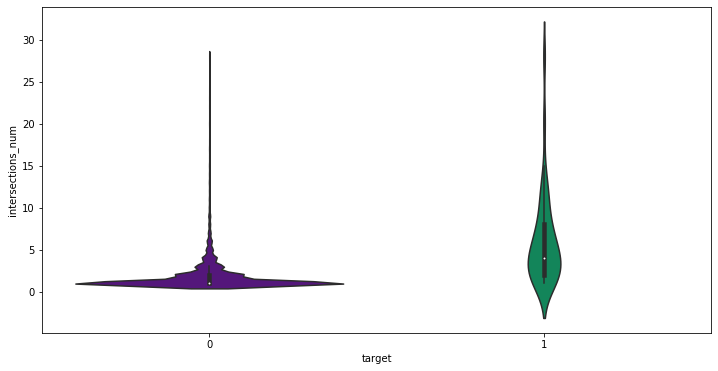

In [43]:
plt.figure(figsize=(12,6))
sns.violinplot(x="target", y="intersections_num", data=joint_train, palette=['#57068c', '#00985f'], split=True)
plt.show()

Можно заметить, что для правильных пар среднее колиество пересечений выше, чем для неправильных пар

Теперь посмотрим на аналогичный график для "нормализованного" количества пересечений:
<br/><i>соотношения = [кол-во пересечений пары / общеее кол-во пересечений 1-ой сим-карты]</i>

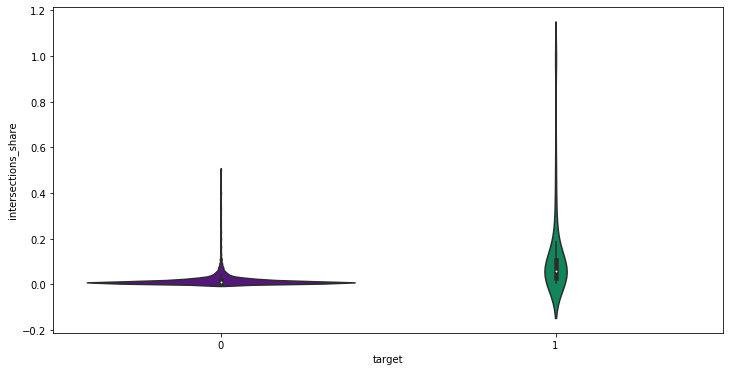

In [44]:
plt.figure(figsize=(12,6))
sns.violinplot(x="target", y="intersections_share", data=joint_train, palette=['#57068c', '#00985f'], split=True)
plt.show()

Аналогично можно заметить, что для правильных пар "нормализованное" колиество пересечений выше, чем для неправильных пар, а также что от определенного значения "нормализованного" количества пересечений неправильные пары перестают встречаться

<i>Может показаться, что для "1" есть значения долей >1, но это не так</i>

In [45]:
print('joint_train.intersections_share.max() =', joint_train.intersections_share.max())

joint_train.intersections_share.max() = 1.0


## <font color='57068c'>Идея 2: реализация (3/3)</font>
Также (для обучения классификатора) <font color='00985f'><b>построим индивидуальные признаки для каждой из сим-карт</b></font>:
* кол-во уникальных сим-карт, с которыми есть пересечения
* общее, медианное, (арифм.) среднее кол-во пересечений
* минимальное и максимальное число пересечений с какой-либо из сим-карт
* кол-во записей в таблице `Data`, относящихся к сим-карте
* кол-во уникальных `imei`, `lac`, `cid` и `lac_cid`
* среднее время нахождения в зоне действия базовой станции
* сумма и доля (от общего числа) каждого из `event_type_0-10` (всего 22=11х2 признака)
* аналогично `event_type` для `cell_type` (6 признаков)
* время регистрации на базовой станции было разбито на 4 периода и посчитаны статистики аналогично `event_type`

Зададим:
* ф-цию, которая описывает сим-карту (т.е. создает признаки) статистиками по пересечениям сим-карты, и
* её имплементацию для набора сим-карт

In [46]:
def generate_intersections_description(msisdn, intersections_count):
    """Returns DataFrame with msisdn as an index and columns - stats,
    related to intersections of the provided msisdn.
    """
    
    assert_text = '{} is not in the provided count-dict.'.format(msisdn)
    assert msisdn in intersections_count, assert_text
    
    intersections = intersections_count[msisdn]
    values = np.array(list(intersections.values()))
    
    stats = {'intersections_unique': len(values),
             'intersections_sum': np.sum(values)}
    if len(values) == 0:
        stats['intersections_median'] = 0
        stats['intersections_mean'] = 0
        stats['intersections_min'] = 0
        stats['intersections_max'] = 0
    else:
        stats['intersections_median'] = np.median(values)
        stats['intersections_mean'] = np.mean(values)
        stats['intersections_min'] = np.min(values)
        stats['intersections_max'] = np.max(values)
    
    intersections_description = pd.DataFrame(stats, index=[msisdn])
    return intersections_description

In [47]:
def generate_intersections_description_for_group(msisdns_group, intersections_count, processes=4):
    """Applies `generate_intersections_description` to the provided group of msisdns."""
    
    msisdns_group = list(msisdns_group)
    
    pool = mp.Pool(processes)
    intersections_descriptions_iter = pool.map(
        partial(generate_intersections_description, intersections_count=intersections_count), msisdns_group
    )
    intersections_descriptions = [msisdn for msisdn in intersections_descriptions_iter]
    intersections_descriptions = pd.concat(intersections_descriptions)
    
    return intersections_descriptions

В этот момент стало ясно, что собранный словарь с пересечениями неисчерпывающий, и его надо пересобирать

In [48]:
msisdns_group_train = set(joint_train.msisdn_a.tolist() + joint_train.msisdn_b.tolist())
msisdns_group_train = list(msisdns_group_train)

In [49]:
if GENERATE:
    intersections_raw_train = create_intersections_raw_batch(data, msisdns_group_train, batch_size=30, name_prefix='train')
    
    with open('intersections_raw_train.pkl', 'wb') as file:
        pickle.dump(intersections_raw_train, file)

else:
    with open('intersections_raw_train.pkl', 'rb') as file:
        intersections_raw_train = pickle.load(file)

In [50]:
intersections_count_train = intersections_raw_processing(intersections_raw_train)
assert len(intersections_count_train) == len(msisdns_group_train)

Пример признаков-статистик по пересечениям

In [51]:
intersections_descriptions_train = generate_intersections_description_for_group(msisdns_group_train, intersections_count_train)
intersections_descriptions_train.head(3)

,intersections_unique,intersections_sum,intersections_median,intersections_mean,intersections_min,intersections_max
158534066181,83,115.0,1.0,1.385542,1,4
158535065609,78,91.0,1.0,1.166667,1,6
158530568203,104,137.0,1.0,1.317308,1,5


<i>Ф-ция ниже понадобится чуть позже</i>

In [52]:
def get_part_of_day(hour):
    """Returns part of the day."""
    
    if 5 <= hour <= 10:
        part_of_the_day = "morning"
    elif 11 <= hour <= 16:
        part_of_the_day = "afternoon"
    elif 17 <= hour <= 22:
        part_of_the_day = "evening"
    else:
    # elif 23 <= hour <= 4:
        part_of_the_day = "night"
    
    return part_of_the_day

Зададим ф-цию, которая описывает сим-карту (т.е. создает признаки), собирая информацию из таблицы `data`

In [53]:
def generate_data_description(data):
    """Returns DataFrame with msisdn as an index and columns - stats,
    aggregated from `data` DataFrame for each msisdn.
    """
    
    cols_description = ['unique_id', 'msisdn', 'lac', 'cid', 'imei', 'event_type', 'tstamp', 'cell_type', 'duration']
    
    data_description = data[cols_description].copy()
    data_description.index = data_description.unique_id
    data_description.drop(columns='unique_id', inplace=True)
    
    
    # event_type one-hot encoding (for future stats)
    event_type = pd.get_dummies(data_description.event_type)
    event_type.columns = ['event_type_'+str(col) for col in event_type.columns]

    data_description = data_description.merge(event_type, how='left', left_index=True, right_index=True)
    data_description.drop(columns=['event_type'], inplace=True)
    
    
    # cell_type one-hot encoding (for future stats)
    cell_type = pd.get_dummies(data_description.cell_type)
    cell_type.columns = ['cell_type_'+str(col) for col in cell_type.columns]

    data_description = data_description.merge(cell_type, how='left', left_index=True, right_index=True)
    data_description.drop(columns=['cell_type'], inplace=True)
    
    
    # part_of_day feature creation and one-hot encoding (for future stats)
    data_description['date_time'] = pd.to_datetime(data_description.tstamp / 1000, unit='s')
    data_description['part_of_day'] = data_description.date_time.dt.hour.apply(get_part_of_day)

    part_of_day = pd.get_dummies(data_description.part_of_day)
    part_of_day.columns = ['part_of_day_'+str(col) for col in part_of_day.columns]

    data_description = data_description.merge(part_of_day, how='left', left_index=True, right_index=True)
    data_description.drop(columns=['part_of_day'], inplace=True)
    
    
    # lac_cid column creation
    data_description['lac_cid'] = data_description.lac.astype(str) + '_' + data_description.cid.astype(str)
    
    
    # aggregation dictionary composing
    # -- regular stats
    agg_dict = {'msisdn': 'count',
                'lac': pd.Series.nunique,
                'cid': pd.Series.nunique,
                'lac_cid': pd.Series.nunique,
                'imei': pd.Series.nunique,
                'duration': np.mean}
    # -- sum and mean for one-hot encoded columns (mean shows share of each col, i.e. normalized sum)
    for df in [event_type, cell_type, part_of_day]:
        for df_col in df.columns:
            agg_dict[df_col] = [np.sum, np.mean]
     
    
    # aggregation of `data`
    data_description_agg = data_description.groupby('msisdn').agg(agg_dict)
    
    
    # renaming aggregated one-hot encoded cols
    new_col_names = []

    for col in data_description_agg.columns:

        special_cols_et = event_type.columns.tolist()
        special_cols_ct = cell_type.columns.tolist()
        special_cols_pd = part_of_day.columns.tolist()
        special_cols = special_cols_et + special_cols_ct + special_cols_pd

        if col[0] in special_cols and col[1] == 'mean':
            col_1 = 'share'
        else:
            col_1 = col[1]

        new_col_name = col[0] + '_' + col_1
        new_col_names.append(new_col_name)

    data_description_agg.columns = new_col_names
    
    
    # FINISH
    return data_description_agg

In [54]:
data_descriptions = generate_data_description(data); data_descriptions.head(3)

,msisdn_count,lac_nunique,cid_nunique,lac_cid_nunique,imei_nunique,duration_mean,event_type_0_sum,event_type_0_share,event_type_1_sum,event_type_1_share,...,cell_type_OUTDOOR_sum,cell_type_OUTDOOR_share,part_of_day_afternoon_sum,part_of_day_afternoon_share,part_of_day_evening_sum,part_of_day_evening_share,part_of_day_morning_sum,part_of_day_morning_share,part_of_day_night_sum,part_of_day_night_share
msisdn,,,,,,,,,,,,,,,,,,,,,
158500002513,8,1,2,2,1.0,2.893806e+07,0.0,0.000000,2.0,0.250000,...,8.0,1.000000,3.0,0.375000,0.0,0.00000,1.0,0.125000,4.0,0.500000
158500006927,143,11,55,55,2.0,2.074332e+06,15.0,0.104895,19.0,0.132867,...,143.0,1.000000,46.0,0.321678,30.0,0.20979,54.0,0.377622,13.0,0.090909
158500010757,117,9,47,47,1.0,2.580567e+06,15.0,0.128205,9.0,0.076923,...,105.0,0.897436,50.0,0.427350,40.0,0.34188,18.0,0.153846,9.0,0.076923


In [55]:
def cosine_distance(vectors_a_b):
    """Returns cosine similarity for two vectors. Vectors
    should be provided as: vectors_a_b = [vector_a, vector_b].
    """
    
    vector_a = vectors_a_b[0]
    vector_b = vectors_a_b[1]
    
    cosine_distance = cosine(vector_a, vector_b)
    return cosine_distance

<b>И, наконец, создадим X и y</b>

In [56]:
def generate_X_y(joint, intersection_descriptions, data_descriptions):
    """Accumulates descriptions to obseravations data set.
    Returns:
    -- index (i.e., pairs: [sim-card_1, sim-card_2])
    -- features (i.e., X)
    -- target (i.e., y)
    """
    
    intersection_descriptions = intersection_descriptions.copy()
    data_descriptions = data_descriptions.copy()

    X = joint.copy()

    # 1st sim-card features
    intersection_descriptions_a = intersection_descriptions.copy()
    intersection_descriptions_a.columns = [col+'_(a)' for col in intersection_descriptions_a.columns]
    data_descriptions_a = data_descriptions.copy()
    data_descriptions_a.columns = [col+'_(a)' for col in data_descriptions_a.columns]

    X = X.merge(intersection_descriptions_a, how='left', left_on='msisdn_a', right_index=True)
    X = X.merge(data_descriptions_a, how='left', left_on='msisdn_a', right_index=True)


    # 2nd sim-card features
    intersection_descriptions_b = intersection_descriptions.copy()
    intersection_descriptions_b.columns = [col+'_(b)' for col in intersection_descriptions_b.columns]
    data_descriptions_b = data_descriptions.copy()
    data_descriptions_b.columns = [col+'_(b)' for col in data_descriptions_b.columns]

    X = X.merge(intersection_descriptions_b, how='left', left_on='msisdn_b', right_index=True)
    X = X.merge(data_descriptions_b, how='left', left_on='msisdn_b', right_index=True)


    # cosine_distance between two sim-cards
    # -- it will work better if vectors' values are normalized
    # -- skip this step for now, cause Scaler should be learned on train-dataset
    # -- and feature for test-dataset should be created via learned Scaler 
    cols_a = [col for col in X.columns if '_(a)' in col]
    cols_b = [col for col in X.columns if '_(b)' in col]

    assert_text = 'Wrong vectors\' values order!'
    for col_a, col_b in zip(cols_a, cols_b):
        assert col_a[:-4] == col_b[:-4], assert_text

    X['vector_a'] = X[cols_a].values.tolist()
    X['vector_b'] = X[cols_b].values.tolist()
    X['vectors_a_b'] = X[['vector_a', 'vector_b']].values.tolist()

    X['cosine_distance'] = X['vectors_a_b'].apply(cosine_distance)
    X.drop(columns=['vector_a', 'vector_b', 'vectors_a_b'], inplace=True)


    # generating returns
    index = X[['msisdn_a', 'msisdn_b']]
    y = X['target']
    X.drop(columns=['msisdn_a', 'msisdn_b', 'target'], inplace=True)


    # sorting columns in X
    pair_feats = ['intersections_num', 'intersections_share', 'cosine_distance']
    for i, feat in enumerate(pair_feats):
        old_name = feat
        new_name = feat + '_(pair)'

        X[new_name] = X[old_name]
        X.drop(columns=[old_name], inplace=True)

        pair_feats[i] = new_name

    msisdn_a_feats = [col for col in X.columns if '_(a)' in col]
    msisdn_b_feats = [col for col in X.columns if '_(b)' in col]

    sorted_feats = pair_feats + msisdn_a_feats + msisdn_b_feats
    X = X[sorted_feats]


    # FINISH
    return index, X, y

In [57]:
index, X, y = generate_X_y(joint_train, intersections_descriptions_train, data_descriptions)
pd.concat([index, X, y], axis=1).head(3)

,msisdn_a,msisdn_b,intersections_num_(pair),intersections_share_(pair),cosine_distance_(pair),intersections_unique_(a),intersections_sum_(a),intersections_median_(a),intersections_mean_(a),intersections_min_(a),...,cell_type_OUTDOOR_share_(b),part_of_day_afternoon_sum_(b),part_of_day_afternoon_share_(b),part_of_day_evening_sum_(b),part_of_day_evening_share_(b),part_of_day_morning_sum_(b),part_of_day_morning_share_(b),part_of_day_night_sum_(b),part_of_day_night_share_(b),target
0,158523272017,158526782893,1,0.023256,4.826272e-08,41,43.0,1.0,1.04878,1,...,0.990291,80.0,0.388350,39.0,0.189320,82.0,0.398058,5.0,0.024272,0
1,158523272017,158590442241,1,0.023256,1.473110e-08,41,43.0,1.0,1.04878,1,...,1.000000,64.0,0.444444,44.0,0.305556,36.0,0.250000,0.0,0.000000,0
2,158523272017,158522023493,2,0.046512,3.787410e-09,41,43.0,1.0,1.04878,1,...,1.000000,30.0,0.357143,17.0,0.202381,26.0,0.309524,11.0,0.130952,0


Зададим ф-ии для обучения Gradient Boosting:
* с тестовой выборкой (для оценки ошибки)
* без теста (для финального обучения)

In [58]:
def lgb_model(lgb_params, X_train, y_train, X_test, y_test):
    """Returns dict with results for LGBoost."""

    out = {}

    lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    lgb_test = lgb.Dataset(X_test, label=y_test, free_raw_data=False)

    lgb_params['seed'] = 17
    lgb_params['bagging_seed'] = 17
    lgb_params['drop_seed'] = 17

    try:
        verbose_eval = lgb_params['verbose_eval']
    except:
        verbose_eval = 100

    out['model'] = lgb.train(lgb_params,
                             lgb_train,
                             valid_sets=[lgb_train, lgb_test],
                             valid_names=['train', 'test'],
                             verbose_eval=verbose_eval)
    out['pred'] = out['model'].predict(X_test)
    out['loss'] = log_loss(y_test, out['pred'])
    return out

In [59]:
def lgb_model_wo_test(lgb_params, X_train, y_train):
    """Returns model learnet on X- , y- _train."""
    
    
    lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
    
    lgb_params['seed'] = 17
    lgb_params['bagging_seed'] = 17
    lgb_params['drop_seed'] = 17

    try:
        verbose_eval = lgb_params['verbose_eval']
    except:
        verbose_eval = 100

    model = lgb.train(lgb_params,
                      lgb_train,
                      valid_sets=[lgb_train],
                      valid_names=['train'],
                      verbose_eval=verbose_eval)
    
    return model

А также ф-цию для кросс-валидации Gradient Boosting'а

In [60]:
def crossval_lgb(X, y, lgb_params, n_splits=3):
    """Cross-validation results LGB"""
    
    crossval_results = {}
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=17)

    for n_fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        if lgb_params['verbose_eval'] > 0:
            print('\n', 'Fold #{}'.format(n_fold + 1))

        X_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y.iloc[test_idx]

        # BOOSTING:
        crossval_results[n_fold] = lgb_model(lgb_params, X_train, y_train, X_test, y_test)

    return crossval_results

Также зададим ф-цию для кросс-валидации моделей библиотеки sklearn

In [61]:
def crossval_sklearn(X, y, model, n_splits=3, std_scaler=True):
    """Cross-validation results for (any) sklearn model."""
    
    crossval_results = {}
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=17)

    for n_fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        
        out = {}

        X_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y.iloc[test_idx]
        
        if std_scaler:
            
            scaler = StandardScaler()
            scaler.fit(X_train)
            
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)

        # MODEL & results storing:
        # -- inasmuch decision to try the sklearn models came late, 
        #    a function with raw model (like `lgb_model()`) was skipped
        out['model'] = model.fit(X_train, y_train)
        out['pred'] = out['model'].predict(X_test)
        out['loss'] = log_loss(y_test, out['pred'])
        
        crossval_results[n_fold] = out

    return crossval_results

И ф-цию, которая выводит на экран результаты кросс-валидации

In [62]:
def print_crossval_losses(crossval_results, alpha=0.05):
    """Prints crossval summary"""

    folds = len(crossval_results)
    
    losses = []
    for i in range(folds):
        fold_loss = crossval_results[i]['loss']
        print('Fold #{}:'.format(i+1), fold_loss)
        losses.append(fold_loss)
    losses = np.array(losses)
    
    print('-'*70)
    loss_mean = losses.mean()
    loss_mean_std = losses.std(ddof=1) / math.sqrt(len(losses))
    conf_int = _tconfint_generic(mean=loss_mean, std_mean=loss_mean_std, dof=len(losses)-1, alpha=alpha, alternative='two-sided')
    print('Mean:', loss_mean, '| Conf. Int.:', conf_int)
    
    print()
    print('\'Avg. Accuracy\':', np.exp(-loss_mean))

Ниже результаты работы логистической регрессии: подобрать такие гипер-параметры, чтобы модель показывала приемлемые результаты не удалось

In [63]:
# logreg = SGDClassifier(loss='log', max_iter=, alpha=0.00000001, n_jobs=-1)
logreg =  LogisticRegression(penalty='l1', tol=100000, solver='liblinear', random_state=17, max_iter=10000)

crossval_results_logreg = crossval_sklearn(X.fillna(X.mean()), y, logreg)
print_crossval_losses(crossval_results_logreg)

Fold #1: 0.5644469294109927
Fold #2: 0.5512222001523318
Fold #3: 0.5514368505417991
----------------------------------------------------------------------
Mean: 0.5557019933683746 | Conf. Int.: (0.5368868928651893, 0.5745170938715598)

'Avg. Accuracy': 0.573669407692896


Ниже результаты работы Gradient Boosting

In [64]:
lgb_params ={
    'task': 'train',
    'objective': 'binary',
    'metric': 'binary_logloss',
    
    'feature_fraction': 0.7, #1
    'subsample': 1, # 1

    'learning_rate': 0.001, # 0.1
    'max_depth': 3, # -1
    'num_leaves': 32, # 31

    'reg_alpha': 2, # 0
    'reg_lambda': 2, # 0

    # 'min_split_gain': 10, #0
    'min_data_in_leaf': 3, #20

    'verbose_eval': -1,
    'verbose': -1,

    'num_iterations': 8634,
    # 'early_stopping_round': 1000
    }

crossval_results = crossval_lgb(X, y, lgb_params, n_splits=3)
print_crossval_losses(crossval_results)

Fold #1: 0.0417412563688056
Fold #2: 0.04314225211241491
Fold #3: 0.04586770227568679
----------------------------------------------------------------------
Mean: 0.0435837369189691 | Conf. Int.: (0.03837114781868511, 0.04879632601925309)

'Avg. Accuracy': 0.95735238499537


Несмотря на то, что accuracy ниже, чем доля преобладающего класса, модель, все равно, может на устроить, т.к., напомним, что основываясь на ее результатах, мы будем выбирать наиболее подходящую пару

Попробуем отобрать признаки по `feature_importance`

In [65]:
def extract_feature_importance(crossval_results, top_n=None):
    """Returns:
        -- feats_idx: features idx sorted by feature_importance
           (1st - the most important, last - the least important)
        -- fi_mean: average (between folds) feature_importance
    """


    fi = []
    for n_split in crossval_results:
        fi_fold = crossval_results[n_split]['model'].feature_importance()
        fi.append(fi_fold)

    fi = np.array(fi)
    fi_mean = fi.mean(axis=0)
    feats_idx = np.flip(fi_mean.argsort())
    fi_mean = fi_mean[feats_idx]

    if top_n:
        feats_idx = feats_idx[0:top_n]
        fi_mean = fi_mean[0:top_n]

    feature_importance = {'idx': feats_idx,
                          'mean': fi_mean}

    return feature_importance

In [66]:
def feature_importance_summary(feature_importance, X):
    """Generates summary table with features and its importance."""

    
    feats = X.columns

    fi_summary = []
    for idx, fi_mean in zip(feature_importance['idx'], feature_importance['mean']):
        row = [feats[idx], fi_mean]
        fi_summary.append(row)
        
    columns = ['feature', 'importance']
    fi_summary = pd.DataFrame(data=fi_summary,
                              columns=columns)
    return fi_summary

In [67]:
feature_importance = extract_feature_importance(crossval_results)
top30_feats = feature_importance['idx'][0:30]
X_top30_feats = X.iloc[:, top30_feats]

feature_importance_summary(feature_importance, X).head(10)

,feature,importance
0,intersections_share_(pair),5576.666667
1,intersections_num_(pair),4999.000000
2,intersections_mean_(a),2048.666667
3,cosine_distance_(pair),1740.333333
4,part_of_day_evening_share_(b),1719.666667
5,part_of_day_morning_share_(b),1683.000000
6,part_of_day_night_share_(b),1536.000000
7,cid_nunique_(b),1502.000000
8,event_type_2_share_(b),1492.666667
9,intersections_mean_(b),1340.666667


* Количество и "нормализованное" количество пересечений пар оказалось наиболее значимыми признаками (что, в целом, можно было предположить).
* Интересно, что на следующем месте идёт косинусное расстояние, что также <b>сигнализирует о том, что, возможно, кластеризация могла бы хорошо помочь в решении задачи</b>

Попробуем обучить модель на ТОП30 признаках

In [68]:
lgb_params_top30_feats ={
    
    'task': 'train',
    'objective': 'binary',
    'metric': 'binary_logloss',
    
    'feature_fraction': 0.7, #1
    'subsample': 1, # 1

    'learning_rate': 0.001, # 0.1
    'max_depth': 3, # -1
    'num_leaves': 32, # 31

    'reg_alpha': 2, # 0
    'reg_lambda': 2, # 0

    # 'min_split_gain': 10, #0
    'min_data_in_leaf': 3, #20

    'verbose_eval': -1,
    'verbose': -1,

    'num_iterations': 10813,
    # 'early_stopping_round': 1500
    }

crossval_results = crossval_lgb(X_top30_feats, y, lgb_params_top30_feats, n_splits=3)
print_crossval_losses(crossval_results)

Fold #1: 0.040178314689277975
Fold #2: 0.04175041500543897
Fold #3: 0.045273459170099284
----------------------------------------------------------------------
Mean: 0.042400729621605404 | Conf. Int.: (0.03591941193536973, 0.04888204730784108)

'Avg. Accuracy': 0.9584856100275464


Различия в результатах получились незначительными, поэтому остановимся на модели, работающей на всём множестве созданных признаков

Теперь посмотрим на <b>тестовую выборку</b>

Результаты работы наивного алгоритма:

In [69]:
msisdns = np.array(pairs_unseen)[:, 0]

true = np.array(pairs_unseen)[:, 1]
preds_top_pair = predict_top_pair(msisdns, intersections_count_facts)

_ = accuracy_for_preds(true, preds_top_pair); print()
_ = accuracy_for_intersections(true, msisdns, intersections_count_facts)

accuracy: 0.25
Conf. Int.:
- Normal: (0.15511365160887547, 0.34488634839112453)
- Wilson: (0.16806231857542375, 0.3548467461923397)

accuracy in intersections: 0.7125
Conf. Int.:
- Normal: (0.6133222031966351, 0.8116777968033649)
- Wilson: (0.6053965378701002, 0.8001307570773007)


Создадим `X` и `y` для `unseen` данных

In [70]:
markup_unseen = generate_markup(pairs_unseen, intersections_count_facts); print()
markup_unseen.head(3)

Total observations #: 3439
Positive observations #: 57



,msisdn_a,msisdn_b,target
0,158530880373,158524216845,0
1,158530880373,158527193343,0
2,158530880373,158523400283,0


In [71]:
intersections_num_feature_unseen = generate_intersections_num_feature(pairs_unseen, intersections_count_facts); print()
intersections_num_feature_unseen.head(3)

Total observations #: 3439
Min value: 1 | Max value: 29



,msisdn_a,msisdn_b,intersections_num,intersections_share
0,158530880373,158524216845,1,0.008065
1,158530880373,158527193343,10,0.080645
2,158530880373,158523400283,2,0.016129


In [72]:
joint_unseen = intersections_num_feature_unseen.merge(markup_unseen,
                                                      how='left',
                                                      on=['msisdn_a', 'msisdn_b'])
joint_unseen.head(3)

,msisdn_a,msisdn_b,intersections_num,intersections_share,target
0,158530880373,158524216845,1,0.008065,0
1,158530880373,158527193343,10,0.080645,0
2,158530880373,158523400283,2,0.016129,0


Дособираем словарь пересечений...

In [73]:
msisdns_group_unseen = set(joint_unseen.msisdn_a.tolist() + joint_unseen.msisdn_b.tolist())
msisdns_group_unseen = list(msisdns_group_unseen)

msisdns_absent = [msisdn for msisdn in msisdns_group_unseen if msisdn not in intersections_count_train]
# 'missing' is more appropriate than 'absent' here, but 'missing' looks very similar to 'msisdn'.

In [74]:
if GENERATE:
    intersections_raw_absent = create_intersections_raw_batch(data, msisdns_absent, batch_size=30, name_prefix='absent')
    
    with open('intersections_raw_absent.pkl', 'wb') as file:
        pickle.dump(intersections_raw_absent, file)

else:
    with open('intersections_raw_absent.pkl', 'rb') as file:
        intersections_raw_absent = pickle.load(file)

...и обновим существующий

In [75]:
intersections_count_absent = intersections_raw_processing(intersections_raw_absent)

intersections_count_train_tmp = intersections_count_train.copy()
intersections_count_train_tmp.update(intersections_count_absent)

intersections_count_unseen = intersections_count_train_tmp.copy()
del intersections_count_train_tmp

In [76]:
intersections_descriptions_unseen = generate_intersections_description_for_group(msisdns_group_unseen, intersections_count_unseen)
intersections_descriptions_unseen.head(3)

,intersections_unique,intersections_sum,intersections_median,intersections_mean,intersections_min,intersections_max
158534066181,83,115.0,1.0,1.385542,1,4
158535065609,78,91.0,1.0,1.166667,1,6
158530568203,104,137.0,1.0,1.317308,1,5


In [77]:
index_unseen, X_unseen, y_unseen = generate_X_y(joint_unseen, intersections_descriptions_unseen, data_descriptions)
pd.concat([index_unseen, X_unseen, y_unseen], axis=1).head(3)

,msisdn_a,msisdn_b,intersections_num_(pair),intersections_share_(pair),cosine_distance_(pair),intersections_unique_(a),intersections_sum_(a),intersections_median_(a),intersections_mean_(a),intersections_min_(a),...,cell_type_OUTDOOR_share_(b),part_of_day_afternoon_sum_(b),part_of_day_afternoon_share_(b),part_of_day_evening_sum_(b),part_of_day_evening_share_(b),part_of_day_morning_sum_(b),part_of_day_morning_share_(b),part_of_day_night_sum_(b),part_of_day_night_share_(b),target
0,158530880373,158524216845,1,0.008065,2.495436e-10,51,124.0,2.0,2.431373,1,...,1.000000,36.0,0.507042,0.0,0.000000,34.0,0.478873,1.0,0.014085,0
1,158530880373,158527193343,10,0.080645,2.850235e-09,51,124.0,2.0,2.431373,1,...,1.000000,48.0,0.410256,21.0,0.179487,33.0,0.282051,15.0,0.128205,0
2,158530880373,158523400283,2,0.016129,3.087672e-10,51,124.0,2.0,2.431373,1,...,0.942857,32.0,0.457143,18.0,0.257143,20.0,0.285714,0.0,0.000000,0


Обучим модель на полном наборе (`train`) данных

<i>P.S.
<br/>Обращаем ваше внимание, что в настоящем ноутбуке `X` и `y` для обучающих выборок обозначаются без префиксов (например, `_train`)</i>

In [78]:
lgb_params ={
    'task': 'train',
    'objective': 'binary',
    'metric': 'binary_logloss',
    
    'feature_fraction': 0.7, #1
    'subsample': 1, # 1

    'learning_rate': 0.001, # 0.1
    'max_depth': 3, # -1
    'num_leaves': 32, # 31

    'reg_alpha': 2, # 0
    'reg_lambda': 2, # 0

    # 'min_split_gain': 10, #0
    'min_data_in_leaf': 3, #20

    'verbose_eval': -1,
    'verbose': 1,

    'num_iterations': 8634,
    # 'early_stopping_round': 1000
    }

model = lgb_model_wo_test(lgb_params, X, y)

Предскажем пары обученной моделью

In [79]:
def generate_preds_via_model(msisdns, model, index, X):

    probs = model.predict(X)

    ranking = index.copy()
    ranking['probs'] = probs

    preds_via_model = []

    for msisdn in msisdns:
        if msisdn not in ranking.msisdn_a.tolist():
            pred = np.nan

        else:
            ranking_msisdn = ranking[ranking.msisdn_a == msisdn]

            max_prob = ranking_msisdn.probs.max()
            ranking_pred = ranking_msisdn[ranking_msisdn.probs == max_prob]

            pred = ranking_pred.msisdn_b.values[0]

        preds_via_model.append(pred)
    
    return preds_via_model

In [80]:
preds_via_model = generate_preds_via_model(msisdns, model, index_unseen, X_unseen)

In [81]:
_ = accuracy_for_preds(true, preds_top_pair); print()
_ = accuracy_for_preds(true, preds_via_model)

accuracy: 0.25
Conf. Int.:
- Normal: (0.15511365160887547, 0.34488634839112453)
- Wilson: (0.16806231857542375, 0.3548467461923397)

accuracy: 0.3625
Conf. Int.:
- Normal: (0.2571590580338784, 0.4678409419661216)
- Wilson: (0.2657079306444915, 0.4718920549777783)


## <font color='57068c'>Идея 2: результаты</font>
Неожиданно <font color='00985f'><b>результаты работы наивного алгоритма на unseen данных оказались хуже</b></font>, чем на train данных:
* <font color='00985f'><b>точность</b></font> составила <font color='00985f'><b>25.0%</b></font> (5%-ый дов. инт.: от 15.5% до 34.5%) <font color='00985f'><b>против 35%</b></font> (5%-ый дов. инт.: от 27.6% до 42.4%) ранее;
* правда, назвать различия статистически значимыми (на уровне 5%) нельзя, т.к. доверительные интервалы (для долей) пересекаются

Стоит отметить, что <font color='00985f'><b>переобучиться наивный алгоритм не мог</b></font>, т.к. он основан просто на статистике пересечений. Так что <font color='00985f'><b>снижение качества — это</b></font>, скорее, <font color='00985f'><b>случайность</b></font> <i>(вина которой выбранный random_state в train_test_split :-))</i>

При этом <font color='57068c'><b>обученный классификатор позволил увеличить точность предсказаний до 36.3%</b></font> (5%-ый дов. инт.: от 25.7% до 46.8%) против 25.0% (5%-ый дов. инт.: от 15.5% до 34.5%) ранее <font color='00985f'><b>на unseen данных</b></font>! Правда, <font color='57068c'><b>пока улучшение статистически не значимо</b></font> (на уровне 5%), т.к. доверительные интервалы пересекаются

Следует отметить, что:
* тюнинг параметров модели практически не осуществлялся, а также
* была произведена лишь поверхностная попытка отбора признаков

Т.е., <font color='00985f'><b>модель была обучена с параметрами практически «из коробки», что означает, что потенциал для улучшения должен быть</b></font>
